# Proposed idea
- What rule?
  - We found that `ap_hi` is an important feature to predict positive/negative class.
  - Usually, if `ap_hi` is high, the risk is high. (more likely positive)
  - So, we set a perturbation-based rule between `ap_hi` and `risk` (output probability).
  
- How to evaluate?
  - According to Kaggle discussion (https://www.kaggle.com/sulianova/cardiovascular-disease-dataset/discussion), the accuracy is almost saturated around 73%.
  - Since it is easy to learn `the rule` (higher ap_hi, higher risk), it won't change the accuracy a lot regardless of the rule.
  - We intentionally split the data into two groups:
      - Group 1: The rule is not very dominant. (Many patients having higher ap_hi don't have the disease.)
      - Group 2: The rule is dominant.
  

## Rule information
- According to data distribution, `ap_hi` is one of the most important feature to predict correct class.
- For example, if we have a very simple rule such as
  - If `ap_hi > 129,5`, then class=1, else class=0.
  - the accuracy will be 71.39%(=(28160 + 21813)/70000).
- According to Kaggle discussion, the best accuracy is only around 73%.
- Thus, the simple rule is pretty strong criterion.

### `ap_hi` and `cardio` statistics
1. \# of `ap_hi <= 129.5` and `cardio=0`: 28160
2. \# of `ap_hi > 129.5` and `cardio=1`: 21813
3. \# of `ap_hi <= 129.5` and `cardio=1`: 13166
4. \# of `ap_hi > 129.5` and `cardio=0`: 6861

- If a model is trained on 1+2 samples, it won't work at all over 3+4 target.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import sys
sys.path.append('..')

import gc
import os
import importlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.utils import shuffle

import utils


df = pd.read_csv(os.path.join('data', 'cardio_train.csv'), delimiter=';')
df = df.drop(['id'], axis=1)

y = df['cardio']
X_raw = df.drop(['cardio'], axis=1)

print("Target class ratio:")
print("# of cardio=1: {}/{} ({:.2f}%)".format(np.sum(y==1), len(y), 100*np.sum(y==1)/len(y)))
print("# of cardio=0: {}/{} ({:.2f}%)".format(np.sum(y==0), len(y), 100*np.sum(y==0)/len(y)))


from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

column_trans = ColumnTransformer(
    [('age_norm', StandardScaler(), ['age']),
     ('height_norm', StandardScaler(), ['height']),
     ('weight_norm', StandardScaler(), ['weight']),
     ('gender_cat', OneHotEncoder(), ['gender']),
     ('ap_hi_norm', StandardScaler(), ['ap_hi']),
     ('ap_lo_norm', StandardScaler(), ['ap_lo']),
     ('cholesterol_cat', OneHotEncoder(), ['cholesterol']),
     ('gluc_cat', OneHotEncoder(), ['gluc']),
     ('smoke_cat', OneHotEncoder(), ['smoke']),
     ('alco_cat', OneHotEncoder(), ['alco']),
     ('active_cat', OneHotEncoder(), ['active']),
    ], remainder='passthrough'
)


X = column_trans.fit_transform(X_raw)
# X = X_raw
num_samples = X.shape[0]
X_np = X.copy()


# seed = 42
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()
# y_true = y_test.copy()


#### Rule : higher ap -> higher risk
rule_threshold = 129.5
rule_ind = 5
rule_feature = 'ap_hi'

low_ap_negative = (df[rule_feature] <= rule_threshold) & (df['cardio'] == 0)    # rule
high_ap_positive = (df[rule_feature] > rule_threshold) & (df['cardio'] == 1)    # rule
low_ap_positive = (df[rule_feature] <= rule_threshold) & (df['cardio'] == 1)    # opposite rule
high_ap_negative = (df[rule_feature] > rule_threshold) & (df['cardio'] == 0)    # opposite rule

#### Samples following a rule
X_rule = X[low_ap_negative | high_ap_positive]
y_rule = y[low_ap_negative | high_ap_positive]
y_rule = y_rule.to_numpy()
X_rule, y_rule = shuffle(X_rule, y_rule, random_state=0)
num_rule_samples = X_rule.shape[0]

#### Samples NOT following a rule
X_norule = X[low_ap_positive | high_ap_negative]
y_norule = y[low_ap_positive | high_ap_negative]
y_norule = y_norule.to_numpy()
X_norule, y_norule = shuffle(X_norule, y_norule, random_state=0)
num_norule_samples = X_norule.shape[0]

#### Build a source dataset
src_rule_ratio = 0.3
src_norule_ratio = 0.7
num_samples_from_norule = int(src_norule_ratio*num_norule_samples)
num_samples_from_rule = int(num_samples_from_norule*src_rule_ratio / (1-src_rule_ratio))

X_src = np.concatenate((X_rule[:num_samples_from_rule], X_norule[:num_samples_from_norule]), axis=0)
y_src = np.concatenate((y_rule[:num_samples_from_rule], y_norule[:num_samples_from_norule]), axis=0)
print()
print("Source dataset statistics:")
print("# of samples following a rule: {}".format(num_samples_from_rule))
print("# of samples NOT following a rule: {}".format(num_samples_from_norule))
print("Rule ratio: {:.2f}%".format(100*num_samples_from_rule/(X_src.shape[0])))

#### Build a target dataset
target_rule_ratio = 0.7
num_samples_from_norule_for_target = X_norule.shape[0] - num_samples_from_norule
num_samples_from_rule_for_target = int(num_samples_from_norule_for_target*target_rule_ratio / (1-target_rule_ratio))
X_target = np.concatenate((X_rule[num_samples_from_rule:num_samples_from_rule+num_samples_from_rule_for_target], 
                           X_norule[num_samples_from_norule:]), axis=0)
y_target = np.concatenate((y_rule[num_samples_from_rule:num_samples_from_rule+num_samples_from_rule_for_target], 
                           y_norule[num_samples_from_norule:]), axis=0)
print()
print("Target dataset statistics:")
print("# of samples following a rule: {}".format(num_samples_from_rule_for_target))
print("# of samples NOT following a rule: {}".format(num_samples_from_norule_for_target))
print("Rule ratio: {:.2f}%".format(100*num_samples_from_rule_for_target/(X_target.shape[0])))

Target class ratio:
# of cardio=1: 34979/70000 (49.97%)
# of cardio=0: 35021/70000 (50.03%)

Source dataset statistics:
# of samples following a rule: 6007
# of samples NOT following a rule: 14018
Rule ratio: 30.00%

Target dataset statistics:
# of samples following a rule: 14020
# of samples NOT following a rule: 6009
Rule ratio: 70.00%


In [101]:
num_samples_from_rule_for_target

14020

In [62]:
i = 14
np.mean(X_src[:,i]), np.mean(X_target[:,i])

(0.08534332084893882, 0.08922063008637475)

<AxesSubplot:>

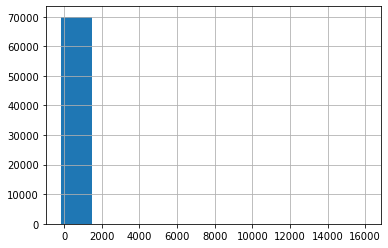

In [46]:
X_raw['ap_hi'].hist()

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

from utils_cardio import *


X_train, X_test, y_train, y_test = train_test_split(X_rule, y_rule, test_size=0.2)

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)


y_true = y_test
y_score = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)


acc, prec, recall, fpr, tpr, roc_auc = get_metrics(y_true, y_pred, y_score)
print('[X_rule] Accuracy: {:.2f} %'.format(100*acc))


y_true = y_src
y_score = clf.predict_proba(X_src)[:, 1]
y_pred = clf.predict(X_src)

acc, prec, recall, fpr, tpr, roc_auc = get_metrics(y_true, y_pred, y_score)
print('[X_src] Accuracy: {:.2f} %'.format(100*acc))

y_true = y_target
y_score = clf.predict_proba(X_target)[:, 1]
y_pred = clf.predict(X_target)

acc, prec, recall, fpr, tpr, roc_auc = get_metrics(y_true, y_pred, y_score)
print('[X_target] Accuracy: {:.2f} %'.format(100*acc))

[X_rule] Accuracy: 100.00 %
[X_src] Accuracy: 30.00 %
[X_target] Accuracy: 70.00 %


In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import scale, StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_src, y_src, test_size=0.2)

#### MLP
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scale = scaler.transform(X_train)
# X_test_scale = scaler.transform(X_test)
X_train_scale = X_train
X_test_scale = X_test

mlpc_model = MLPClassifier().fit(X_train_scale, y_train)

y_true = y_test
y_score = mlpc_model.predict_proba(X_test_scale)[:,1]
y_pred = mlpc_model.predict(X_test_scale)

acc, prec, recall, fpr, tpr, roc_auc = get_metrics(y_true, y_pred, y_score)
print('[X_rule] Accuracy: {:.2f} %'.format(100*acc))


# y_true = y_src
# y_score = mlpc_model.predict_proba(scaler.transform(X_src))[:,1]
# y_pred = mlpc_model.predict(scaler.transform(X_src))

# acc, prec, recall, fpr, tpr, roc_auc = get_metrics(y_true, y_pred, y_score)
# print('[X_src] Accuracy: {:.2f} %'.format(100*acc))

y_true = y_target
# y_score = mlpc_model.predict_proba(scaler.transform(X_target))[:,1]
# y_pred = mlpc_model.predict(scaler.transform(X_target))
y_score = mlpc_model.predict_proba(X_target)[:,1]
y_pred = mlpc_model.predict(X_target)

acc, prec, recall, fpr, tpr, roc_auc = get_metrics(y_true, y_pred, y_score)
print('[X_target] Accuracy: {:.2f} %'.format(100*acc))

[X_rule] Accuracy: 70.46 %
[X_target] Accuracy: 40.24 %


In [388]:
src_rule_ratio, target_rule_ratio

(0.3, 0.7)

In [2]:
'''
Data preprocessing for NN
'''
import random
from copy import deepcopy

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from model import RuleEncoder, DataEncoder, Net, NaiveModel, SharedNet, DataonlyNet

from utils_cardio import *



seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 70:10:20 split
train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2
train_X, test_X, train_y, test_y = train_test_split(X_src, y_src, test_size=1-train_ratio, random_state=seed)
valid_X, test_X, valid_y, test_y = train_test_split(test_X, test_y, test_size=test_ratio/(test_ratio + validation_ratio), random_state=seed)

train_X, train_y = torch.tensor(train_X, dtype=torch.float32, device=device), torch.tensor(train_y, dtype=torch.float32, device=device)
valid_X, valid_y = torch.tensor(valid_X, dtype=torch.float32, device=device), torch.tensor(valid_y, dtype=torch.float32, device=device)
test_X, test_y = torch.tensor(test_X, dtype=torch.float32, device=device), torch.tensor(test_y, dtype=torch.float32, device=device)

total_train_sample = len(train_X)
total_valid_sample = len(valid_X)
total_test_sample = len(test_X)

batch_size = 32
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_X, valid_y), batch_size=valid_X.shape[0])
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=test_X.shape[0])

print("data size: {}/{}/{}".format(len(train_X), len(valid_X), len(test_X)))

data size: 14017/2002/4006


In [4]:
from torch.distributions.beta import Beta

from model import RuleEncoder, DataEncoder, Net
from utils_learning import verification, get_perturbed_input

model_info = {'dataonly': {'rule': 0.0},
              'ours-beta1.0': {'beta': [1.0], 'scale': 1.0, 'lr': 0.001},
              'ours-beta0.1': {'beta': [0.1], 'scale': 1.0, 'lr': 0.001},
              'ours-beta0.1-pert0.01': {'beta': [0.1], 'pert': 0.01},
              'ours-beta0.1-scale0.1': {'beta': [0.1], 'scale': 0.1},
              'ours-beta0.1-scale0.05': {'beta': [0.1], 'scale': 0.05},
              'ours-beta0.1-scale0.01': {'beta': [0.1], 'scale': 0.01},
              'ours-beta1.0-scale0.01': {'beta': [1.0], 'scale': 0.01},
             }
              
    
ret_dict = dict()


# for model_type in ['dataonly', 'ours-beta0.1', 'ours-beta1.0']:
for model_type in ['ours-beta0.1-scale0.01', 'ours-beta1.0-scale0.01']:
    
    if model_type not in model_info:
        # default setting
        lr = 0.001
        rule_coeff = 0.0
        pert_coeff = 0.1
        scale = 1.0
        beta_param = [1.0]
        alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        model_params = {}
        reverse = False
    else:
        model_params = model_info[model_type]
        lr = model_params['lr'] if 'lr' in model_params else 0.001
        rule_coeff = model_params['rule'] if 'rule' in model_params else 0.0
        pert_coeff = model_params['pert'] if 'pert' in model_params else 0.1
        scale = model_params['scale'] if 'scale' in model_params else 1.0
        beta_param = model_params['beta'] if 'beta' in model_params else [1.0]
        reverse = model_params['reverse'] if 'reverse' in model_params else False
        if len(beta_param) == 1:
            alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
        elif len(beta_param) == 2:
            alpha_distribution = Beta(float(beta_param[0]), float(beta_param[1]))
            
    print('model_type: {}\tscale:{}\tBeta distribution: Beta({})\tlr: {}\trule_coeff: {}\tpert_coeff: {}'.format(model_type, scale, beta_param, lr, rule_coeff, pert_coeff))

    
    ret_dict[model_type] = {}

    for seed in range(0,1):

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        if model_type.startswith('dataonly'):
            merge = 'cat'
        elif model_type.startswith('ours'):
            merge = 'cat'
        elif model_type.startswith('ruleonly'):
            merge = 'cat'

        input_dim = 19
        hidden_dim = 100
        emb_dim = 16
        output_dim = 1
        
        rule_encoder = RuleEncoder(input_dim, emb_dim, hidden_dim)
        data_encoder = DataEncoder(input_dim, emb_dim, hidden_dim)
        model = Net(_, 1, rule_encoder, data_encoder, hidden_dim=16, n_layers=1, merge='cat').to(device)    # Not residual connection

        rule_weight = torch.tensor(model.rule_encoder.net[0].weight)
        data_weight = torch.tensor(model.data_encoder.net[0].weight)

        total_params = sum(p.numel() for p in model.parameters())
        print("total parameters: {}".format(total_params))

        loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
#         loss_task_func = nn.MSELoss()    # return scalar (reduction=mean)
        loss_task_func = nn.BCELoss()    # return scalar (reduction=mean)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        
        epochs = 1000 if model_type.startswith('ours') else 100
        early_stopping_thld = 10
        counter_early_stopping = 1
        log_interval = 500
        valid_freq = 1
        saved_filename = 'cardio_{}_rule-{}_src{}-target{}_seed{}.demo.pt'.format(model_type, rule_feature, src_rule_ratio, target_rule_ratio, seed)
        saved_filename =  os.path.join('saved_models', saved_filename)
        print('saved_filename: {}\n'.format(saved_filename))
        best_val_loss = float('inf')

        # Training
        for epoch in range(1, epochs+1):
            model.train()
            for batch_train_x, batch_train_y in train_loader:
                batch_train_y = batch_train_y.unsqueeze(-1)

                optimizer.zero_grad()

                if model_type.startswith('dataonly'):
                    alpha = 0.0
                elif model_type.startswith('ruleonly'):
                    alpha = 1.0
                elif model_type.startswith('ours'):
                    alpha = alpha_distribution.sample().item()

                # stable output
                output = model(batch_train_x, alpha=alpha)    # only rule if alpha=1.    \hat{X}_{t+1}
                loss_task = loss_task_func(output, batch_train_y)

                # perturbed input and its output
                pert_batch_train_x = batch_train_x.detach().clone()
                pert_batch_train_x[:,rule_ind] = get_perturbed_input(pert_batch_train_x[:,rule_ind], pert_coeff)
                pert_output = model(pert_batch_train_x, alpha=alpha)    # \hat{y}_{p}    predicted sales from perturbed input

                loss_rule = loss_rule_func(output, pert_output)    # output should be less than pert_output
                    
                loss = alpha * loss_rule + scale * (1-alpha) * loss_task

                loss.backward()
                optimizer.step()


            # Evaluate on validation set
            if epoch % valid_freq == 0:
                model.eval()
                if  model_type.startswith('ruleonly'):
                    alpha = 1.0
                else:
                    alpha = 0.0

                with torch.no_grad():
                    for val_x, val_y in valid_loader:
                        val_y = val_y.unsqueeze(-1)
                        
                    output = model(val_x, alpha=alpha)
                    val_loss_task = loss_task_func(output, val_y).item()
                    
                    # perturbed input and its output
                    pert_val_x = val_x.detach().clone()
                    pert_val_x[:,rule_ind] = get_perturbed_input(pert_val_x[:,rule_ind], pert_coeff)
                    pert_output = model(pert_val_x, alpha=alpha)    # \hat{y}_{p}    predicted sales from perturbed input
                        
                    val_loss_rule = loss_rule_func(output, pert_output).item()
                    val_ratio = verification(pert_output, output, threshold=0.0).item()
                    
                    val_loss = val_loss_task
                    
                    y_true = val_y.cpu().numpy()
                    y_score = output.cpu().numpy()
                    y_pred = np.round(y_score)
                    val_acc = 100*accuracy_score(y_true, y_pred)
                    
                if val_loss < best_val_loss:
                    counter_early_stopping = 1
                    best_val_loss = val_loss
                    best_model_state_dict = deepcopy(model.state_dict())
                    print('[Valid] Epoch: {} Loss: {:.6f} (alpha: {:.2f})\t Loss(Task): {:.6f} Acc: {:.2f}\t Loss(Rule): {:.6f}\t Ratio: {:.4f} best model is updated %%%%'
                          .format(epoch, best_val_loss, alpha, val_loss_task, val_acc, val_loss_rule, val_ratio))
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': best_model_state_dict,
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_val_loss
                    }, saved_filename)
                else:
                    print('[Valid] Epoch: {} Loss: {:.6f} (alpha: {:.2f})\t Loss(Task): {:.6f} Acc: {:.2f}\t Loss(Rule): {:.6f}\t Ratio: {:.4f}({}/{})'
                          .format(epoch, val_loss, alpha, val_loss_task, val_acc, val_loss_rule, val_ratio, counter_early_stopping, early_stopping_thld))
                    if counter_early_stopping >= early_stopping_thld:
                        break
                    else:
                        counter_early_stopping += 1

        # Test
        rule_encoder = RuleEncoder(input_dim, emb_dim, hidden_dim)
        data_encoder = DataEncoder(input_dim, emb_dim, hidden_dim)
        model_eval = Net(_, 1, rule_encoder, data_encoder, hidden_dim=16, n_layers=1, merge='cat').to(device)    # Not residual connection

        checkpoint = torch.load(saved_filename)
        model_eval.load_state_dict(checkpoint['model_state_dict'])
        print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

        model_eval.eval()
        with torch.no_grad():
            for te_x, te_y in test_loader:
                te_y = te_y.unsqueeze(-1)

            output = model_eval(te_x, alpha=0.0)
            test_loss_task = loss_task_func(output, te_y).item()

        print('\n[Test] Average loss: {:.8f}\n'.format(test_loss_task))

        #### Check which parameters are updated.
        print('Is rule_weight NOT udpated: {}'.format(torch.allclose(rule_weight, torch.tensor(model.rule_encoder.net[0].weight))))
        print('Is data_weight NOT udpated: {}'.format(torch.allclose(data_weight, torch.tensor(model.data_encoder.net[0].weight))))
        print()

        #### Best model
        test_loss_alpha = []
        test_acc_alpha = []
        test_ratio_alpha = []
        alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        
        # perturbed input and its output
        pert_test_x = te_x.detach().clone()
        pert_test_x[:,rule_ind] = get_perturbed_input(pert_test_x[:,rule_ind], pert_coeff)
        for alpha in alphas:
            model_eval.eval()
            with torch.no_grad():
                for te_x, te_y in test_loader:
                    te_y = te_y.unsqueeze(-1)
                    
                if model_type.startswith('dataonly'):
                    output = model_eval(te_x, alpha=0.0)
                elif model_type.startswith('ours'):
                    output = model_eval(te_x, alpha=alpha)
                elif model_type.startswith('ruleonly'):
                    output = model_eval(te_x, alpha=1.0)

                test_loss_task = loss_task_func(output, te_y).item()  # sum up batch loss

                if model_type.startswith('dataonly'):
                    pert_output = model_eval(pert_test_x, alpha=0.0)    # \hat{y}_{p}    predicted sales from perturbed input
                elif model_type.startswith('ours'):
                    pert_output = model_eval(pert_test_x, alpha=alpha)    # \hat{y}_{p}    predicted sales from perturbed input
                elif model_type.startswith('ruleonly'):
                    pert_output = model_eval(pert_test_x, alpha=1.0)    # \hat{y}_{p}    predicted sales from perturbed input

                test_ratio = verification(pert_output, output, threshold=0.0).item()
                
                y_true = te_y.cpu().numpy()
                y_score = output.cpu().numpy()
                y_pred = np.round(y_score)
                test_acc = accuracy_score(y_true, y_pred)

            print('[Test] Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))
            print('[Test] Accuracy: {:.4f} (alpha:{})'.format(test_acc, alpha))
            print("[Test] Ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))
            print()

            test_loss_alpha.append(test_loss_task)
            test_acc_alpha.append(test_acc)
            test_ratio_alpha.append(test_ratio)

        ret_dict[model_type][seed] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha, 'test_acc': test_acc_alpha}
        print()
        print()
        print()

model_type: ours-beta0.1-scale0.01	scale:0.01	Beta distribution: Beta([0.1])	lr: 0.001	rule_coeff: 0.0	pert_coeff: 0.1
total parameters: 7265
saved_filename: saved_models/cardio_ours-beta0.1-scale0.01_rule-ap_hi_src0.3-target0.7_seed0.demo.pt

[Valid] Epoch: 1 Loss: 0.653891 (alpha: 0.00)	 Loss(Task): 0.653891 Acc: 61.24	 Loss(Rule): 0.000142	 Ratio: 0.6334 best model is updated %%%%
[Valid] Epoch: 2 Loss: 0.648608 (alpha: 0.00)	 Loss(Task): 0.648608 Acc: 60.54	 Loss(Rule): 0.000371	 Ratio: 0.6334 best model is updated %%%%
[Valid] Epoch: 3 Loss: 0.648426 (alpha: 0.00)	 Loss(Task): 0.648426 Acc: 61.24	 Loss(Rule): 0.000489	 Ratio: 0.6334 best model is updated %%%%
[Valid] Epoch: 4 Loss: 0.642302 (alpha: 0.00)	 Loss(Task): 0.642302 Acc: 61.74	 Loss(Rule): 0.000550	 Ratio: 0.6334 best model is updated %%%%
[Valid] Epoch: 5 Loss: 0.648114 (alpha: 0.00)	 Loss(Task): 0.648114 Acc: 61.49	 Loss(Rule): 0.000638	 Ratio: 0.6334(1/10)
[Valid] Epoch: 6 Loss: 0.640860 (alpha: 0.00)	 Loss(Task): 0.6

In [129]:
colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']*20
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

for key, val in ret_dict.items():
    test_loss_list = []
    test_ratio_list = []
    test_acc_list = []
    for seed, subval in val.items():
        if isinstance(seed, int):
#             if seed != 0:
#                 continue
            test_loss_list.append(subval['test_loss'])
            test_acc_list.append(subval['test_acc'])
            test_ratio_list.append(subval['test_ratio'])
            
            
    val['test_loss_avg'] = np.mean(np.array(test_loss_list), 0)
    val['test_loss_std'] = np.std(np.array(test_loss_list), 0)
    val['test_acc_avg'] = np.mean(np.array(test_acc_list), 0)
    val['test_acc_std'] = np.std(np.array(test_acc_list), 0)
    val['test_ratio_avg'] = np.mean(np.array(test_ratio_list), 0)
    val['test_ratio_std'] = np.std(np.array(test_ratio_list), 0)


# key_list = ret_dict.keys()
key_list = ['dataonly',  'ours-beta0.1-scale0.1', 'ours-beta0.1-scale0.05', 'ours-beta0.1-scale0.01']


i, ii = 0, 10
plt.figure(0, figsize=(15,10))
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
    plt.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='MAE ({})'.format(key))
    plt.fill_between(alphas[:ii], val['test_loss_avg'][:ii] - val['test_loss_std'][:ii], val['test_loss_avg'][:ii] + val['test_loss_std'][:ii], color=colors[i], alpha=0.3)
    i += 1
    
plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')
# plt.ylim(0.0007, 0.003)

i, ii = 0, 10
plt.figure(1, figsize=(15,10))
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
    plt.plot(alphas[:ii], val['test_acc_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='Accuracy ({})'.format(key))
    plt.fill_between(alphas[:ii], val['test_acc_avg'][:ii] - val['test_acc_std'][:ii], val['test_acc_avg'][:ii] + val['test_acc_std'][:ii], color=colors[i], alpha=0.3)
    i += 1
    
plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')


plt.figure(2, figsize=(15,10))
i = 0
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
    plt.plot(alphas, val['test_ratio_avg'], ltype, color=colors[i], lw=4, ms=15, label='Verification Ratio ({})'.format(key))
    plt.fill_between(alphas, val['test_ratio_avg'] - val['test_ratio_std'], val['test_ratio_avg'] + val['test_ratio_std'], color=colors[i], alpha=0.3)
    i += 1

plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')

NameError: name 'ret_dict' is not defined

In [207]:
# X_src = np.concatenate((X_rule[:num_samples_from_rule], X_norule[:num_samples_from_norule]), axis=0)
# y_src = np.concatenate((y_rule[:num_samples_from_rule], y_norule[:num_samples_from_norule]), axis=0)

# X_target = np.concatenate((X_rule[num_samples_from_rule:num_samples_from_rule+num_samples_from_rule_for_target], 
#                            X_norule[num_samples_from_norule:]), axis=0)
# y_target = np.concatenate((y_rule[num_samples_from_rule:num_samples_from_rule+num_samples_from_rule_for_target], 
#                            y_norule[num_samples_from_norule:]), axis=0)

# datasplit = 'source'
# X_target = X_src
# y_target = y_src
# dataratio = 0.30

# offset = 20000
# datasplit = 'target1'
# X_target = np.concatenate((X_rule[num_samples_from_rule:num_samples_from_rule+offset], X_norule[num_samples_from_norule:]), axis=0)
# y_target = np.concatenate((y_rule[num_samples_from_rule:num_samples_from_rule+offset], y_norule[num_samples_from_norule:]), axis=0)
# dataratio = offset / X_target.shape[0]
# print('rule: norule = {}:{}\t ratio(usual): {:.2f}'.format(offset, X_norule.shape[0] - num_samples_from_norule, dataratio))


offset = 6000
datasplit = 'target2'
X_target = np.concatenate((X_rule[num_samples_from_rule:num_samples_from_rule+offset], X_norule[num_samples_from_norule:]), axis=0)
y_target = np.concatenate((y_rule[num_samples_from_rule:num_samples_from_rule+offset], y_norule[num_samples_from_norule:]), axis=0)
dataratio = offset / X_target.shape[0]
print('rule: norule = {}:{}\t ratio(usual): {:.2f}'.format(offset, X_norule.shape[0] - num_samples_from_norule, dataratio))

# offset = 4000
# datasplit = 'target3'
# X_target = np.concatenate((X_rule[num_samples_from_rule:num_samples_from_rule+offset], X_norule[num_samples_from_norule:]), axis=0)
# y_target = np.concatenate((y_rule[num_samples_from_rule:num_samples_from_rule+offset], y_norule[num_samples_from_norule:]), axis=0)
# dataratio = offset / X_target.shape[0]
# print('rule: norule = {}:{}\t ratio(usual): {:.2f}'.format(offset, X_norule.shape[0] - num_samples_from_norule, dataratio))

rule: norule = 6000:6009	 ratio(usual): 0.50


In [208]:
import random
from copy import deepcopy

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from model import RuleEncoder, DataEncoder, Net, NaiveModel, SharedNet, DataonlyNet

from torch.distributions.beta import Beta

from model import RuleEncoder, DataEncoder, Net
from utils_learning import verification, get_perturbed_input
'''
Load saved models and evaluate them
'''


target_X, target_y = torch.tensor(X_target, dtype=torch.float32, device=device), torch.tensor(y_target, dtype=torch.float32, device=device)
# target_X, target_y = torch.tensor(X_src[:1000], dtype=torch.float32, device=device), torch.tensor(y_src[:1000], dtype=torch.float32, device=device)
target_loader = DataLoader(TensorDataset(target_X, target_y), batch_size=target_X.shape[0])

target_ret_dict = dict()
pert_coeff = 0.1
loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
loss_task_func = nn.BCELoss()    # return scalar (reduction=mean)
for seed in range(1,10):

#     for model_type in ['dataonly', 'ours-beta0.1', 'ours-beta1.0']:
    for model_type in ['dataonly', 'ours-beta0.1-scale0.1', 'ours-beta0.1-scale0.05', 'ours-beta0.1-scale0.01', 'ours-beta1.0-scale0.01']:

        if model_type not in target_ret_dict:
            target_ret_dict[model_type] = {}
            
#         saved_filename = 'cardio_{}_rule-{}_seed{}.demo.pt'.format(model_type, rule_feature, seed)
        saved_filename = 'cardio_{}_rule-{}_src{}-target{}_seed{}.demo.pt'.format(model_type, rule_feature, src_rule_ratio, target_rule_ratio, seed)
        saved_filename =  os.path.join('saved_models', saved_filename)

        
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        if model_type.startswith('dataonly'):
            merge = 'cat'
        elif model_type == 'dataonly-equal':
            merge = 'equal_cat'
        elif model_type.startswith('ours'):
            merge = 'cat'
        elif model_type.startswith('ruleonly'):
            merge = 'cat'

        input_dim = 19
        hidden_dim = 100
        emb_dim = 16
        output_dim = 1

        rule_encoder = RuleEncoder(input_dim, emb_dim, hidden_dim)
        data_encoder = DataEncoder(input_dim, emb_dim, hidden_dim)
        model = Net(_, 1, rule_encoder, data_encoder, hidden_dim=16, n_layers=1, merge='cat').to(device)    # Not residual connection

        checkpoint = torch.load(saved_filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

        checkpoint = torch.load(saved_filename)
        total_params = sum(p.numel() for p in model.parameters())
        print("loaded filename: {}".format(saved_filename))
        print("total parameters: {}".format(total_params))

        model.eval()
        with torch.no_grad():
            for tgt_x, tgt_y in target_loader:
                tgt_y = tgt_y.unsqueeze(-1)
        pert_test_x = tgt_x.detach().clone()
        pert_test_x[:,rule_ind] = get_perturbed_input(pert_test_x[:,rule_ind], pert_coeff)
        
        with torch.no_grad():

            #### Best model
            test_loss_alpha = []
            test_acc_alpha = []
            test_auc_alpha = []
            test_ratio_alpha = []
            alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
            for alpha in alphas:

                if model_type.startswith('dataonly'):
                    output = model(tgt_x, alpha=0.0)
                elif model_type.startswith('ours'):
                    output = model(tgt_x, alpha=alpha)
                elif model_type.startswith('ruleonly'):
                    output = model(tgt_x, alpha=1.0)

                test_loss_task = loss_task_func(output, tgt_y).item()  # sum up batch loss

                if model_type.startswith('dataonly'):
                    pert_output = model(pert_test_x, alpha=0.0)    # \hat{y}_{p}    predicted sales from perturbed input
                elif model_type.startswith('ours'):
                    pert_output = model(pert_test_x, alpha=alpha)    # \hat{y}_{p}    predicted sales from perturbed input
                elif model_type.startswith('ruleonly'):
                    pert_output = model(pert_test_x, alpha=1.0)    # \hat{y}_{p}    predicted sales from perturbed input

                test_ratio = verification(pert_output, output, threshold=0.0).item()

                y_true = tgt_y.cpu().numpy()
                y_score = output.cpu().numpy()
                y_pred = np.round(y_score)
                test_acc = accuracy_score(y_true, y_pred)
                test_auc = roc_auc_score(y_true, y_score)

                print('[Target] set: Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))
                print('[Target] set: Accuracy: {:.4f} (alpha:{})'.format(test_acc, alpha))
                print('[Target] set: AUC: {:.4f} (alpha:{})'.format(test_auc, alpha))
                print("[Target] Ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))
                print()

                test_loss_alpha.append(test_loss_task)
                test_acc_alpha.append(test_acc)
                test_auc_alpha.append(test_auc)
                test_ratio_alpha.append(test_ratio)

            target_ret_dict[model_type][seed] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha, 'test_acc': test_acc_alpha, 'test_auc': test_auc_alpha}
            print()
            print()
            print()
            
            
            

best model loss: 0.572605	 at epoch: 32
loaded filename: saved_models/cardio_dataonly_rule-ap_hi_src0.3-target0.7_seed1.demo.pt
total parameters: 7265
[Target] set: Average loss: 0.72323412 (alpha:0.0)
[Target] set: Accuracy: 0.5670 (alpha:0.0)
[Target] set: AUC: 0.6091 (alpha:0.0)
[Target] Ratio of verified predictions: 0.761262 (alpha:0.0)

[Target] set: Average loss: 0.72323412 (alpha:0.1)
[Target] set: Accuracy: 0.5670 (alpha:0.1)
[Target] set: AUC: 0.6091 (alpha:0.1)
[Target] Ratio of verified predictions: 0.761262 (alpha:0.1)

[Target] set: Average loss: 0.72323412 (alpha:0.2)
[Target] set: Accuracy: 0.5670 (alpha:0.2)
[Target] set: AUC: 0.6091 (alpha:0.2)
[Target] Ratio of verified predictions: 0.761262 (alpha:0.2)

[Target] set: Average loss: 0.72323412 (alpha:0.3)
[Target] set: Accuracy: 0.5670 (alpha:0.3)
[Target] set: AUC: 0.6091 (alpha:0.3)
[Target] Ratio of verified predictions: 0.761262 (alpha:0.3)

[Target] set: Average loss: 0.72323412 (alpha:0.4)
[Target] set: Accuracy

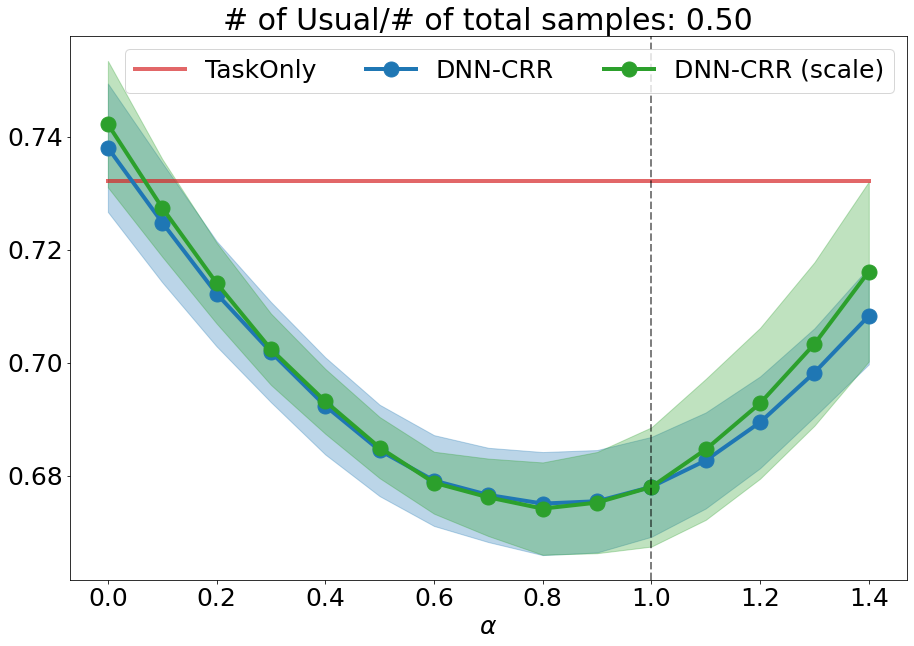

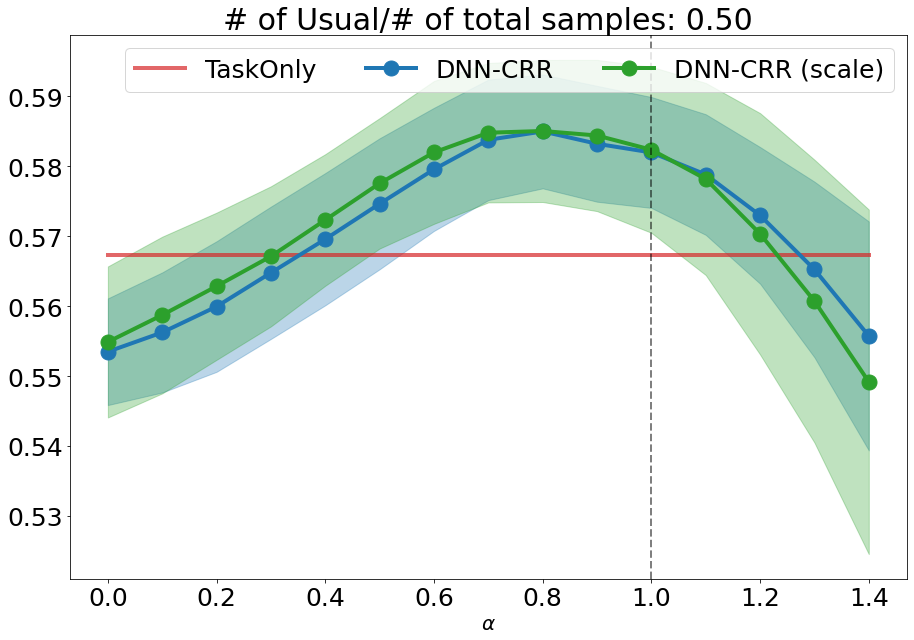

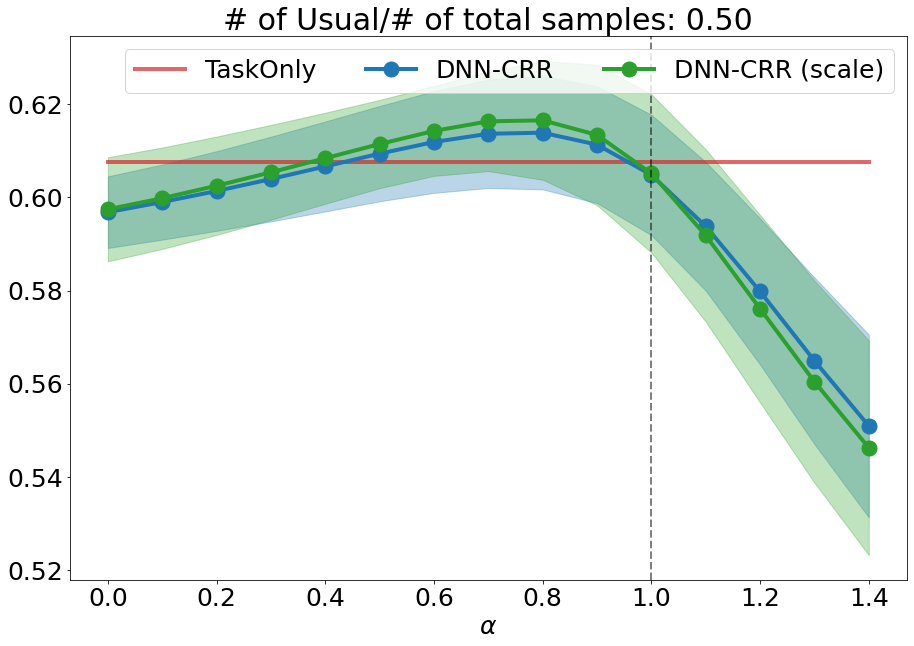

In [209]:
target_ret_dict['TaskOnly'] = target_ret_dict['dataonly']
target_ret_dict['Ours'] = target_ret_dict['ours-beta0.1-scale0.1']
target_ret_dict['Ours-Scale'] = target_ret_dict['ours-beta0.1-scale0.05']

colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']*20
# alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]

for key, val in target_ret_dict.items():
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    test_ratio_list = []
    for seed, subval in val.items():
        if isinstance(seed, int):
#             if seed != 0:
#                 continue
            test_loss_list.append(subval['test_loss'])
            test_acc_list.append(subval['test_acc'])
            test_auc_list.append(subval['test_auc'])
            test_ratio_list.append(subval['test_ratio'])
            
    val['test_loss_avg'] = np.mean(np.array(test_loss_list), 0)
    val['test_loss_std'] = np.std(np.array(test_loss_list), 0)
    val['test_acc_avg'] = np.mean(np.array(test_acc_list), 0)
    val['test_acc_std'] = np.std(np.array(test_acc_list), 0)
    val['test_auc_avg'] = np.mean(np.array(test_auc_list), 0)
    val['test_auc_std'] = np.std(np.array(test_auc_list), 0)
    val['test_ratio_avg'] = np.mean(np.array(test_ratio_list), 0)
    val['test_ratio_std'] = np.std(np.array(test_ratio_list), 0)

key_list = target_ret_dict.keys()
# key_list = ['dataonly', 'ours-beta0.1-scale0.1', 'ours-beta0.1-scale0.05', 'ours-beta0.1-scale0.01']
key_list = ['TaskOnly', 'Ours', 'Ours-Scale']

i, ii = 0, 15
plt.figure(0, figsize=(15,10))
for key in key_list:
    val = target_ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
#     plt.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='MAE ({})'.format(key))
#     if not key.startswith('dataonly'):
#         plt.fill_between(alphas[:ii], val['test_loss_avg'][:ii] - val['test_loss_std'][:ii], val['test_loss_avg'][:ii] + val['test_loss_std'][:ii], color=colors[i], alpha=0.3)
    if key == 'TaskOnly':
        plt.plot(alphas[:ii], val['test_loss_avg'][:ii], ls='solid', color='tab:red', alpha=0.7, lw=4, ms=15, label='TaskOnly')
    elif key == 'Ours':
        plt.plot(alphas[:ii], val['test_loss_avg'][:ii], 'o-', color='tab:blue', lw=4, ms=15, label='DNN-CRR')
        plt.fill_between(alphas[:ii], val['test_loss_avg'][:ii] - val['test_loss_std'][:ii], val['test_loss_avg'][:ii] + val['test_loss_std'][:ii], color='tab:blue', alpha=0.3)
    elif key == 'Ours-Scale':
        plt.plot(alphas[:ii], val['test_loss_avg'][:ii], 'o-', color='tab:green', lw=4, ms=15, label='DNN-CRR (scale)')
        plt.fill_between(alphas[:ii], val['test_loss_avg'][:ii] - val['test_loss_std'][:ii], val['test_loss_avg'][:ii] + val['test_loss_std'][:ii], color='tab:green', alpha=0.3)
        
    i += 1
    
plt.axvline(x=1.0, linestyle='--', color='k', linewidth=2, alpha=0.5)
plt.title('# of Usual/# of total samples: {:.2f}'.format(dataratio), fontsize=30)
plt.xlabel(r'$\alpha$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25, ncol=3)
# plt.ylim(0.0007, 0.003)
plt.savefig('img/cardio-da-source-to-{}-CE.pdf'.format(datasplit), bbox_inches='tight')

i, ii = 0, 15
plt.figure(1, figsize=(15,10))
for key in key_list:
    val = target_ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
#     plt.plot(alphas[:ii], val['test_acc_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='Accuracy ({})'.format(key))
#     if not key.startswith('dataonly'):
#         plt.fill_between(alphas[:ii], val['test_acc_avg'][:ii] - val['test_acc_std'][:ii], val['test_acc_avg'][:ii] + val['test_acc_std'][:ii], color=colors[i], alpha=0.3)
    if key == 'TaskOnly':
        plt.plot(alphas[:ii], val['test_acc_avg'][:ii], ls='solid', color='tab:red', alpha=0.7, lw=4, ms=15, label='TaskOnly')
    elif key == 'Ours':
        plt.plot(alphas[:ii], val['test_acc_avg'][:ii], 'o-', color='tab:blue', lw=4, ms=15, label='DNN-CRR')
        plt.fill_between(alphas[:ii], val['test_acc_avg'][:ii] - val['test_acc_std'][:ii], val['test_acc_avg'][:ii] + val['test_acc_std'][:ii], color='tab:blue', alpha=0.3)
    elif key == 'Ours-Scale':
        plt.plot(alphas[:ii], val['test_acc_avg'][:ii], 'o-', color='tab:green', lw=4, ms=15, label='DNN-CRR (scale)')
        plt.fill_between(alphas[:ii], val['test_acc_avg'][:ii] - val['test_acc_std'][:ii], val['test_acc_avg'][:ii] + val['test_acc_std'][:ii], color='tab:green', alpha=0.3)
        
    i += 1
    
plt.axvline(x=1.0, linestyle='--', color='k', linewidth=2, alpha=0.5)
plt.title('# of Usual/# of total samples: {:.2f}'.format(dataratio), fontsize=30)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25, ncol=3)
plt.savefig('img/cardio-da-source-to-{}-ACC.pdf'.format(datasplit), bbox_inches='tight')


plt.figure(2, figsize=(15,10))
i, ii = 0, 15
for key in key_list:
    val = target_ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
#     plt.plot(alphas, val['test_auc_avg'], ltype, color=colors[i], lw=4, ms=15, label='AUC ({})'.format(key))
#     if not key.startswith('dataonly'):
#         plt.fill_between(alphas, val['test_auc_avg'] - val['test_auc_std'], val['test_auc_avg'] + val['test_auc_std'], color=colors[i], alpha=0.3)
    if key == 'TaskOnly':
        plt.plot(alphas[:ii], val['test_auc_avg'][:ii], ls='solid', color='tab:red', alpha=0.7, lw=4, ms=15, label='TaskOnly')
    elif key == 'Ours':
        plt.plot(alphas[:ii], val['test_auc_avg'][:ii], 'o-', color='tab:blue', lw=4, ms=15, label='DNN-CRR')
        plt.fill_between(alphas[:ii], val['test_auc_avg'][:ii] - val['test_auc_std'][:ii], val['test_auc_avg'][:ii] + val['test_auc_std'][:ii], color='tab:blue', alpha=0.3)
    elif key == 'Ours-Scale':
        plt.plot(alphas[:ii], val['test_auc_avg'][:ii], 'o-', color='tab:green', lw=4, ms=15, label='DNN-CRR (scale)')
        plt.fill_between(alphas[:ii], val['test_auc_avg'][:ii] - val['test_auc_std'][:ii], val['test_auc_avg'][:ii] + val['test_auc_std'][:ii], color='tab:green', alpha=0.3)
        
    i += 1

plt.axvline(x=1.0, linestyle='--', color='k', linewidth=2, alpha=0.5)
plt.title('# of Usual/# of total samples: {:.2f}'.format(dataratio), fontsize=30)
plt.xlabel(r'$\alpha$', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25, ncol=3)
plt.savefig('img/cardio-da-source-to-{}-AUC.pdf'.format(datasplit), bbox_inches='tight')

# plt.figure(3, figsize=(15,10))
# i = 0
# for key in key_list:
#     val = target_ret_dict[key]
#     ltype = '-' if key.startswith('dataonly') else 'o-'
#     plt.plot(alphas, val['test_ratio_avg'], ltype, color=colors[i], lw=4, ms=15, label='Verification Ratio ({})'.format(key))
#     plt.fill_between(alphas, val['test_ratio_avg'] - val['test_ratio_std'], val['test_ratio_avg'] + val['test_ratio_std'], color=colors[i], alpha=0.3)
#     i += 1

# plt.xlabel(r'$\alpha$', fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.2), ncol=2, loc='upper center')

In [375]:
target_ret_dict.keys()

dict_keys(['dataonly', 'ours-beta0.1', 'ours-beta1.0', 'ours-beta0.1-pert0.01'])

In [409]:
summary_dict = dict()
key_list = ['dataonly', 'ours-beta0.1', 'ours-beta0.1-scale0.1', 'ours-beta0.1-scale0.05']
for key in key_list:
    summary_dict[key] = dict()
    src_test_loss_min = []
    src_test_acc_max = []
    tgt_test_loss_min = []
    tgt_test_acc_max = []
    diff_test_loss_min = []
    diff_test_acc_max = []
    for seed in range(0,10):
        src_test_loss_min.append(np.min(ret_dict[key][seed]['test_loss']))
        src_test_acc_max.append(np.max(ret_dict[key][seed]['test_acc']))
        tgt_test_loss_min.append(np.min(target_ret_dict[key][seed]['test_loss']))
        tgt_test_acc_max.append(np.max(target_ret_dict[key][seed]['test_acc']))
        diff_test_loss_min.append(np.min(target_ret_dict[key][seed]['test_loss']) - np.min(ret_dict[key][seed]['test_loss']))    # test_loss is increased.
        diff_test_acc_max.append(np.max(target_ret_dict[key][seed]['test_acc']) - np.max(ret_dict[key][seed]['test_acc']))    # test_acc is decreased.
        
    summary_dict[key]['src_test_loss_min'] = src_test_loss_min
    summary_dict[key]['src_test_acc_max'] = src_test_acc_max
    summary_dict[key]['tgt_test_loss_min'] = tgt_test_loss_min
    summary_dict[key]['tgt_test_acc_max'] = tgt_test_acc_max
    summary_dict[key]['diff_test_loss_min'] = diff_test_loss_min
    summary_dict[key]['diff_test_acc_max'] = diff_test_acc_max

In [414]:
np.mean(summary_dict['dataonly']['diff_test_acc_max'])

-0.27568518409165427

In [415]:
np.mean(summary_dict['ours-beta0.1-scale0.05']['diff_test_acc_max'])

-0.15049659646034466

In [380]:
tgt_summary_dict

{'dataonly': {'test_loss_min': [0.9093560576438904,
   0.8634504675865173,
   0.9046406149864197,
   0.9156956076622009,
   0.889617383480072,
   0.8485172390937805,
   0.8973309993743896,
   0.8548700213432312,
   0.8403770923614502,
   0.8752633333206177],
  'test_acc_max': [0.4086574467022817,
   0.4254830495781117,
   0.4431074941335064,
   0.3879874182435469,
   0.4332717559538669,
   0.40461331069948575,
   0.4500474312247241,
   0.4387637925008737,
   0.4385141544760098,
   0.42718058814718657]},
 'ours-beta0.1': {'test_loss_min': [0.7439045906066895,
   0.7636792659759521,
   0.7843639254570007,
   0.7642958760261536,
   0.8219599723815918,
   0.7220775485038757,
   0.7742596864700317,
   0.7679009437561035,
   0.756584107875824,
   0.7468879818916321],
  'test_acc_max': [0.49682959708422786,
   0.47835638324429575,
   0.49598082779969044,
   0.4894902391532278,
   0.4135004243846423,
   0.49268560587148635,
   0.5075640321533776,
   0.463128463727595,
   0.5273353637226023,
  

In [74]:
model_type = 'dataonly'
saved_filename = 'cardio_{}_rule-{}_seed{}.demo.pt'.format(model_type, rule_feature, seed)
saved_filename =  os.path.join('saved_models', saved_filename)

rule_encoder = RuleEncoder(input_dim, emb_dim, hidden_dim)
data_encoder = DataEncoder(input_dim, emb_dim, hidden_dim)
model_eval = Net(_, 1, rule_encoder, data_encoder, hidden_dim=16, n_layers=1, merge='cat').to(device)    # Not residual connection

checkpoint = torch.load(saved_filename)
model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))
        
#### Best model
test_loss_alpha = []
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# perturbed input and its output
for alpha in alphas:
    model_eval.eval()
    with torch.no_grad():
        for te_x, te_y in test_loader:
            te_y = te_y.unsqueeze(-1)

        if model_type.startswith('dataonly'):
            output = model_eval(te_x, alpha=0.0)
        elif model_type.startswith('ours'):
            output = model_eval(te_x, alpha=alpha)
        elif model_type.startswith('ruleonly'):
            output = model_eval(te_x, alpha=1.0)

        test_loss_task = loss_task_func(output, te_y).item()  # sum up batch loss

    print('[Test] Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))

    test_loss_alpha.append(test_loss_task)

ret_dict[model_type][seed] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha}
print()


        
loss_cm /= total_cm_samples
y_score = np.array(y_score)
y_pred = np.round(np.array(y_score))    # classification

if model_type not in model_types:
    model_types.append(model_type) 
acc_dict[model_type], prec_dict[model_type], recall_dict[model_type], fpr_dict[model_type], tpr_dict[model_type], roc_auc_dict[model_type] = get_metrics(y_true, y_pred, y_score)
print('[{}] Accuracy: {:.2f} %'.format(model_type, 100*acc_dict[model_type]))


After learning...
[ours-beta1.0] Accuracy: 97.40 %


In [10]:
from sklearn.tree import DecisionTreeClassifier
from utils_cardio import *



fpr_dict = dict()
tpr_dict = dict()
roc_auc_dict = dict()
acc_dict = dict()
prec_dict = dict()
recall_dict = dict()
model_types = []

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_true = y_test.copy()

clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)

y_score = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)


model_type = 'dtree'
acc_dict[model_type], prec_dict[model_type], recall_dict[model_type], fpr_dict[model_type], tpr_dict[model_type], roc_auc_dict[model_type] = get_metrics(y_true, y_pred, y_score)
print('[{}] Accuracy: {:.2f} %'.format(model_type, 100*acc_dict[model_type]))

[dtree] Accuracy: 73.51 %


In [27]:
# df_sub = df[low_ap_positive | high_ap_negative]

# y_sub = df_sub['cardio']
# X_sub = df.drop(['cardio'], axis=1)

# y_sub = y[low_ap_positive | high_ap_negative]
# X_sub = X[low_ap_positive | high_ap_negative]

y_sub = y[low_ap_negative | high_ap_positive]
X_sub = X[low_ap_negative | high_ap_positive]

In [26]:
X_sub.shape

(20027, 19)

In [28]:
accuracy_score(y_sub, clf.predict(X_sub))

0.923798851379745